# **Extracción y clasificación con segmentación semántica**

**Por**: Pedro Ruiz

---

**Notebook de detección de objetos** usando *Transfer Learning* con **Faster R-CNN**.

Este notebook se divide en **5 secciones principales** para aplicar *Transfer Learning* sobre un clasificador de detección de objetos utilizando el modelo **Faster R-CNN**:

1. **Importaciones**
2. **Configuración**
3. **Cargar Modelo Preentrenado**
4. **Procesamiento**
5. **Visualización**

## Importaciones

In [ ]:
import os
import configparser
import torch
from PIL import Image
from torchvision import transforms
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
import torchvision
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Configuraciones

In [6]:
config = configparser.ConfigParser()
config.read('../config/settings.conf')

processed_data_path = config['data']['processed_data_path']
detection_results_semantic_path = config['data']['detection_results_semantic_path']
os.makedirs(detection_results_semantic_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Mask R-CNN preentrenado en COCO

A continuación, implementaremos el código del *pipeline* para la **detección de objetos** en los fotogramas de los vídeos. Para ello, utilizaremos un modelo preentrenado **Mask R-CNN** con pesos de *COCO*.  

El resultado será un archivo **CSV** por vídeo que contendrá la información sobre:  
- Los **objetos detectados**.  
- Las **puntuaciones** de confianza.  
- Las **áreas delimitadas** (*bounding boxes*).

In [ ]:
# importamos el modelo preentrenado
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)
model.eval().to(device)

transform = transforms.ToTensor()                                                           # Transformación para convertir imágenes PIL a tensores.

# Etiquetas de COCO
coco_labels = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant',
    'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'toilet', 'N/A', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Procesador de vidkeos
def process_video(video_dir, output_csv_path):                                              # Procesa todos los frames y guarda los resultados en un CSV.
    frames = [fr for fr in os.listdir(video_dir) if fr.endswith('.jpg')]                    # Extrae los nombres de los frames.
    frames.sort()                                                                           # y asegura su orden
    results = []

    for frame_name in tqdm(frames, desc=f"Procesando {os.path.basename(video_dir)}"):       # Itera sobre los frames y añadimos una barra de progreso.
        frame_path = os.path.join(video_dir, frame_name)                                    # creamos la ruta del frame,
        img = Image.open(frame_path).convert("RGB")                                         # cargamos la imagen y la convertimos a RGB
        img_t = transform(img).to(device).unsqueeze(0)                                      # y por ultimo transformamos la imagen, agregamos capa y la movemos añ dispositivo.

        with torch.no_grad():                                                               # Desactivamos el cálculo de gradientes
            prediction = model(img_t)[0]                                                    # y generamos la predicción.

        # Predicciones
        boxes = prediction['boxes']                                                         # Coordenadas de los cuadros delimitadores,
        labels = prediction['labels']                                                       # etiquetas de las clases detectadas,
        scores = prediction['scores']                                                       # puntuacion de la confianza,
        masks = prediction.get('masks', None)                                               # máscaras binarizadas,
        width, height = img.width, img.height                                               # y dimensiones de la imagen.

        score_threshold = 0.5                                                               # Umbral de confianza.
        for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):                # Iteramos sobre las predicciones,
            if score >= score_threshold:                                                    # si el es mas alto que el del umbral,
                class_id = label.item()                                                     # transformamos la etiqueta a entero,
                class_name = coco_labels[class_id] if class_id < len(coco_labels) else f"class_{class_id}"                  # asocia la etiqueta con el nombre de clase,
                x1, y1, x2, y2 = box.tolist()                                               # extrae las coordenadas del cuadro,
                w = x2 - x1                                                                 # calcula el ancho.
                h = y2 - y1                                                                 # calcula la altura.
                area_box = w * h                                                            # calcula el área del cuadro delimitador.
                results.append([frame_name, class_name, score.item(), area_box])            # y añade los resultados a la lista.

    df = pd.DataFrame(results, columns=["frame_id", "object", "score", "area"])             # Creamos y guardamos un df con los resultados.
    df.to_csv(output_csv_path, index=False)
    print(f"Guardado CSV en {output_csv_path}")

In [5]:
# Procesa cada categoría y video en el dataset
for category in os.listdir(processed_data_path):                                            # Itera sobre las categorías preprocessadas.
    category_path = os.path.join(processed_data_path, category)
    if os.path.isdir(category_path):                                                        # verifica si se trata de un directorio.
        category_output_dir = os.path.join(detection_results_semantic_path, category)       # Genera el directorio de salida
        os.makedirs(category_output_dir, exist_ok=True)

        for video_dir in os.listdir(category_path):                                         # Itera sobre los videos dentro las categorías.
            video_path = os.path.join(category_path, video_dir)
            if os.path.isdir(video_path): 
                output_csv = os.path.join(category_output_dir, f"{video_dir}.csv") 
                process_video(video_path, output_csv)                                       # y procesa el video, guardando los resultados en el CSV.

Procesando cooking_000001: 100%|██████████| 754/754 [00:46<00:00, 16.13it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000001.csv


Procesando cooking_000002: 100%|██████████| 1172/1172 [01:19<00:00, 14.72it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000002.csv


Procesando cooking_000003: 100%|██████████| 270/270 [00:17<00:00, 15.25it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000003.csv


Procesando cooking_000004: 100%|██████████| 843/843 [00:46<00:00, 18.02it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000004.csv


Procesando cooking_000005: 100%|██████████| 534/534 [00:39<00:00, 13.59it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000005.csv


Procesando cooking_000006: 100%|██████████| 800/800 [00:51<00:00, 15.45it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000006.csv


Procesando cooking_000007: 100%|██████████| 1068/1068 [01:02<00:00, 17.03it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000007.csv


Procesando cooking_000008: 100%|██████████| 1122/1122 [01:17<00:00, 14.50it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000008.csv


Procesando cooking_000009: 100%|██████████| 674/674 [00:36<00:00, 18.42it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000009.csv


Procesando cooking_000010: 100%|██████████| 1301/1301 [01:24<00:00, 15.31it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000010.csv


Procesando cooking_000011: 100%|██████████| 972/972 [01:09<00:00, 13.91it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000011.csv


Procesando cooking_000012: 100%|██████████| 527/527 [00:29<00:00, 17.95it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000012.csv


Procesando cooking_000013: 100%|██████████| 620/620 [00:40<00:00, 15.36it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000013.csv


Procesando cooking_000014: 100%|██████████| 411/411 [00:21<00:00, 18.83it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000014.csv


Procesando cooking_000015: 100%|██████████| 386/386 [00:20<00:00, 19.04it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000015.csv


Procesando cooking_000016: 100%|██████████| 1181/1181 [01:10<00:00, 16.86it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000016.csv


Procesando cooking_000017: 100%|██████████| 546/546 [00:31<00:00, 17.44it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000017.csv


Procesando cooking_000018: 100%|██████████| 520/520 [00:29<00:00, 17.80it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000018.csv


Procesando cooking_000019: 100%|██████████| 505/505 [00:26<00:00, 19.42it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000019.csv


Procesando cooking_000020: 100%|██████████| 330/330 [00:19<00:00, 17.26it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000020.csv


Procesando cooking_000021: 100%|██████████| 863/863 [00:54<00:00, 15.97it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000021.csv


Procesando cooking_000022: 100%|██████████| 512/512 [00:28<00:00, 17.80it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000022.csv


Procesando cooking_000023: 100%|██████████| 906/906 [00:58<00:00, 15.53it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000023.csv


Procesando cooking_000024: 100%|██████████| 497/497 [00:29<00:00, 16.84it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000024.csv


Procesando cooking_000025: 100%|██████████| 670/670 [00:42<00:00, 15.95it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000025.csv


Procesando cooking_000026: 100%|██████████| 590/590 [00:34<00:00, 16.94it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000026.csv


Procesando cooking_000027: 100%|██████████| 481/481 [00:26<00:00, 18.02it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000027.csv


Procesando cooking_000028: 100%|██████████| 598/598 [00:32<00:00, 18.14it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000028.csv


Procesando cooking_000029: 100%|██████████| 1457/1457 [01:27<00:00, 16.58it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000029.csv


Procesando cooking_000030: 100%|██████████| 1073/1073 [01:07<00:00, 15.83it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000030.csv


Procesando cooking_000031: 100%|██████████| 1077/1077 [01:04<00:00, 16.82it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000031.csv


Procesando cooking_000032: 100%|██████████| 295/295 [00:16<00:00, 17.46it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000032.csv


Procesando cooking_000033: 100%|██████████| 993/993 [00:58<00:00, 17.11it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000033.csv


Procesando cooking_000034: 100%|██████████| 992/992 [01:00<00:00, 16.45it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000034.csv


Procesando cooking_000035: 100%|██████████| 1107/1107 [01:30<00:00, 12.23it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000035.csv


Procesando cooking_000036: 100%|██████████| 229/229 [00:16<00:00, 13.60it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000036.csv


Procesando cooking_000037: 100%|██████████| 780/780 [00:50<00:00, 15.32it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000037.csv


Procesando cooking_000038: 100%|██████████| 766/766 [00:49<00:00, 15.53it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000038.csv


Procesando cooking_000039: 100%|██████████| 996/996 [01:01<00:00, 16.07it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000039.csv


Procesando cooking_000040: 100%|██████████| 750/750 [00:44<00:00, 16.75it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000040.csv


Procesando cooking_000041: 100%|██████████| 705/705 [00:42<00:00, 16.53it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000041.csv


Procesando cooking_000042: 100%|██████████| 798/798 [00:50<00:00, 15.78it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000042.csv


Procesando cooking_000043: 100%|██████████| 869/869 [00:50<00:00, 17.11it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000043.csv


Procesando cooking_000044: 100%|██████████| 708/708 [00:41<00:00, 16.88it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000044.csv


Procesando cooking_000045: 100%|██████████| 22/22 [00:01<00:00, 17.04it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000045.csv


Procesando cooking_000046: 100%|██████████| 1006/1006 [01:01<00:00, 16.49it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000046.csv


Procesando cooking_000047: 100%|██████████| 735/735 [00:48<00:00, 15.09it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000047.csv


Procesando cooking_000048: 100%|██████████| 1188/1188 [01:13<00:00, 16.15it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000048.csv


Procesando cooking_000049: 100%|██████████| 456/456 [00:32<00:00, 13.90it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000049.csv


Procesando cooking_000050: 100%|██████████| 876/876 [00:54<00:00, 15.98it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000050.csv


Procesando cooking_000051: 100%|██████████| 1108/1108 [01:02<00:00, 17.65it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000051.csv


Procesando cooking_000052: 100%|██████████| 978/978 [00:59<00:00, 16.56it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000052.csv


Procesando cooking_000053: 100%|██████████| 758/758 [00:44<00:00, 16.87it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000053.csv


Procesando cooking_000054: 100%|██████████| 758/758 [00:45<00:00, 16.75it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000054.csv


Procesando cooking_000055: 100%|██████████| 678/678 [00:38<00:00, 17.55it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000055.csv


Procesando cooking_000056: 100%|██████████| 982/982 [00:57<00:00, 17.22it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000056.csv


Procesando cooking_000057: 100%|██████████| 1072/1072 [01:09<00:00, 15.52it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000057.csv


Procesando cooking_000058: 100%|██████████| 1072/1072 [01:10<00:00, 15.31it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000058.csv


Procesando cooking_000059: 100%|██████████| 386/386 [00:21<00:00, 18.31it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000059.csv


Procesando cooking_000060: 100%|██████████| 482/482 [00:27<00:00, 17.29it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000060.csv


Procesando cooking_000061: 100%|██████████| 1054/1054 [01:01<00:00, 17.15it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000061.csv


Procesando cooking_000062: 100%|██████████| 577/577 [00:33<00:00, 17.21it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000062.csv


Procesando cooking_000063: 100%|██████████| 251/251 [00:13<00:00, 18.36it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000063.csv


Procesando cooking_000064: 100%|██████████| 875/875 [00:54<00:00, 15.96it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000064.csv


Procesando cooking_000065: 100%|██████████| 546/546 [00:30<00:00, 18.11it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000065.csv


Procesando cooking_000066: 100%|██████████| 405/405 [00:23<00:00, 17.06it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000066.csv


Procesando cooking_000067: 100%|██████████| 919/919 [01:01<00:00, 14.88it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000067.csv


Procesando cooking_000068: 100%|██████████| 651/651 [00:38<00:00, 17.11it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000068.csv


Procesando cooking_000069: 100%|██████████| 1808/1808 [02:51<00:00, 10.52it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000069.csv


Procesando cooking_000070: 100%|██████████| 1418/1418 [01:11<00:00, 19.93it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000070.csv


Procesando cooking_000071: 100%|██████████| 133/133 [00:06<00:00, 19.06it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000071.csv


Procesando cooking_000072: 100%|██████████| 205/205 [00:11<00:00, 17.97it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000072.csv


Procesando cooking_000073: 100%|██████████| 678/678 [00:39<00:00, 17.08it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000073.csv


Procesando cooking_000074: 100%|██████████| 358/358 [00:21<00:00, 16.55it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000074.csv


Procesando cooking_000075: 100%|██████████| 105/105 [00:06<00:00, 16.17it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000075.csv


Procesando cooking_000076: 100%|██████████| 745/745 [00:42<00:00, 17.48it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000076.csv


Procesando cooking_000077: 100%|██████████| 220/220 [00:15<00:00, 14.40it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000077.csv


Procesando cooking_000078: 100%|██████████| 453/453 [00:30<00:00, 14.92it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000078.csv


Procesando cooking_000079: 100%|██████████| 787/787 [00:53<00:00, 14.67it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000079.csv


Procesando cooking_000080: 100%|██████████| 473/473 [00:29<00:00, 16.23it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000080.csv


Procesando cooking_000081: 100%|██████████| 385/385 [00:22<00:00, 16.88it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000081.csv


Procesando cooking_000082: 100%|██████████| 1101/1101 [01:16<00:00, 14.37it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000082.csv


Procesando cooking_000083: 100%|██████████| 220/220 [00:15<00:00, 14.33it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000083.csv


Procesando cooking_000084: 100%|██████████| 606/606 [00:33<00:00, 17.98it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000084.csv


Procesando cooking_000085: 100%|██████████| 594/594 [00:33<00:00, 17.61it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000085.csv


Procesando cooking_000086: 100%|██████████| 273/273 [00:14<00:00, 18.64it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000086.csv


Procesando cooking_000087: 100%|██████████| 982/982 [00:56<00:00, 17.31it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000087.csv


Procesando cooking_000088: 100%|██████████| 3267/3267 [03:52<00:00, 14.05it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000088.csv


Procesando cooking_000089: 100%|██████████| 1279/1279 [01:19<00:00, 16.06it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000089.csv


Procesando cooking_000090: 100%|██████████| 542/542 [00:32<00:00, 16.91it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000090.csv


Procesando cooking_000091: 100%|██████████| 618/618 [00:35<00:00, 17.27it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000091.csv


Procesando cooking_000092: 100%|██████████| 287/287 [00:16<00:00, 16.98it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000092.csv


Procesando cooking_000093: 100%|██████████| 3124/3124 [03:03<00:00, 17.04it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000093.csv


Procesando cooking_000094: 100%|██████████| 297/297 [00:18<00:00, 16.05it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000094.csv


Procesando cooking_000095: 100%|██████████| 988/988 [01:02<00:00, 15.71it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000095.csv


Procesando cooking_000096: 100%|██████████| 770/770 [00:41<00:00, 18.43it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000096.csv


Procesando cooking_000097: 100%|██████████| 1216/1216 [01:17<00:00, 15.72it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000097.csv


Procesando cooking_000098: 100%|██████████| 809/809 [00:47<00:00, 17.00it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000098.csv


Procesando cooking_000099: 100%|██████████| 1381/1381 [01:36<00:00, 14.37it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000099.csv


Procesando cooking_000100: 100%|██████████| 558/558 [00:30<00:00, 18.37it/s]


Guardado CSV en ../data/detection_results_semantic\cooking\cooking_000100.csv


Procesando traffic_000001: 100%|██████████| 4903/4903 [04:08<00:00, 19.71it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000001.csv


Procesando traffic_000002: 100%|██████████| 2981/2981 [03:37<00:00, 13.68it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000002.csv


Procesando traffic_000003: 100%|██████████| 4140/4140 [05:18<00:00, 12.99it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000003.csv


Procesando traffic_000004: 100%|██████████| 2770/2770 [03:08<00:00, 14.67it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000004.csv


Procesando traffic_000005: 100%|██████████| 2504/2504 [02:11<00:00, 19.01it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000005.csv


Procesando traffic_000006: 100%|██████████| 1524/1524 [01:34<00:00, 16.19it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000006.csv


Procesando traffic_000007: 100%|██████████| 3852/3852 [04:18<00:00, 14.89it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000007.csv


Procesando traffic_000008: 100%|██████████| 1951/1951 [01:40<00:00, 19.35it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000008.csv


Procesando traffic_000009: 100%|██████████| 1650/1650 [01:51<00:00, 14.82it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000009.csv


Procesando traffic_000010: 100%|██████████| 3759/3759 [03:39<00:00, 17.16it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000010.csv


Procesando traffic_000011: 100%|██████████| 3284/3284 [04:15<00:00, 12.87it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000011.csv


Procesando traffic_000012: 100%|██████████| 5079/5079 [05:04<00:00, 16.71it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000012.csv


Procesando traffic_000013: 100%|██████████| 2212/2212 [02:27<00:00, 15.04it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000013.csv


Procesando traffic_000014: 100%|██████████| 2632/2632 [03:00<00:00, 14.57it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000014.csv


Procesando traffic_000015: 100%|██████████| 1883/1883 [01:28<00:00, 21.28it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000015.csv


Procesando traffic_000016: 100%|██████████| 4485/4485 [04:40<00:00, 15.97it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000016.csv


Procesando traffic_000017: 100%|██████████| 3990/3990 [04:07<00:00, 16.14it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000017.csv


Procesando traffic_000018: 100%|██████████| 3619/3619 [04:14<00:00, 14.23it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000018.csv


Procesando traffic_000019: 100%|██████████| 1770/1770 [01:41<00:00, 17.51it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000019.csv


Procesando traffic_000020: 100%|██████████| 4001/4001 [04:25<00:00, 15.07it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000020.csv


Procesando traffic_000021: 100%|██████████| 1894/1894 [02:05<00:00, 15.04it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000021.csv


Procesando traffic_000022: 100%|██████████| 3195/3195 [03:04<00:00, 17.29it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000022.csv


Procesando traffic_000023: 100%|██████████| 2560/2560 [02:47<00:00, 15.27it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000023.csv


Procesando traffic_000024: 100%|██████████| 3545/3545 [04:09<00:00, 14.20it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000024.csv


Procesando traffic_000025: 100%|██████████| 3021/3021 [03:15<00:00, 15.44it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000025.csv


Procesando traffic_000026: 100%|██████████| 2181/2181 [02:31<00:00, 14.36it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000026.csv


Procesando traffic_000027: 100%|██████████| 3181/3181 [03:25<00:00, 15.51it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000027.csv


Procesando traffic_000028: 100%|██████████| 4662/4662 [04:48<00:00, 16.16it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000028.csv


Procesando traffic_000029: 100%|██████████| 4580/4580 [04:45<00:00, 16.05it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000029.csv


Procesando traffic_000030: 100%|██████████| 3058/3058 [03:33<00:00, 14.31it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000030.csv


Procesando traffic_000031: 100%|██████████| 4475/4475 [04:58<00:00, 15.00it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000031.csv


Procesando traffic_000032: 100%|██████████| 3218/3218 [03:45<00:00, 14.30it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000032.csv


Procesando traffic_000033: 100%|██████████| 3815/3815 [03:56<00:00, 16.16it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000033.csv


Procesando traffic_000034: 100%|██████████| 3919/3919 [04:34<00:00, 14.26it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000034.csv


Procesando traffic_000035: 100%|██████████| 6344/6344 [07:47<00:00, 13.58it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000035.csv


Procesando traffic_000036: 100%|██████████| 2814/2814 [03:23<00:00, 13.80it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000036.csv


Procesando traffic_000037: 100%|██████████| 2777/2777 [03:07<00:00, 14.84it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000037.csv


Procesando traffic_000038: 100%|██████████| 2969/2969 [03:45<00:00, 13.15it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000038.csv


Procesando traffic_000039: 100%|██████████| 2741/2741 [03:27<00:00, 13.23it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000039.csv


Procesando traffic_000040: 100%|██████████| 3195/3195 [03:32<00:00, 15.06it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000040.csv


Procesando traffic_000041: 100%|██████████| 3246/3246 [03:35<00:00, 15.04it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000041.csv


Procesando traffic_000042: 100%|██████████| 2546/2546 [02:52<00:00, 14.74it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000042.csv


Procesando traffic_000043: 100%|██████████| 3178/3178 [03:53<00:00, 13.63it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000043.csv


Procesando traffic_000044: 100%|██████████| 2777/2777 [02:51<00:00, 16.17it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000044.csv


Procesando traffic_000045: 100%|██████████| 3967/3967 [04:05<00:00, 16.16it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000045.csv


Procesando traffic_000046: 100%|██████████| 5065/5065 [06:49<00:00, 12.36it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000046.csv


Procesando traffic_000047: 100%|██████████| 4849/4849 [04:59<00:00, 16.18it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000047.csv


Procesando traffic_000048: 100%|██████████| 4042/4042 [05:10<00:00, 13.04it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000048.csv


Procesando traffic_000049: 100%|██████████| 5743/5743 [07:00<00:00, 13.64it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000049.csv


Procesando traffic_000050: 100%|██████████| 2195/2195 [02:20<00:00, 15.63it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000050.csv


Procesando traffic_000051: 100%|██████████| 2717/2717 [03:17<00:00, 13.79it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000051.csv


Procesando traffic_000052: 100%|██████████| 796/796 [00:42<00:00, 18.93it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000052.csv


Procesando traffic_000053: 100%|██████████| 4183/4183 [04:46<00:00, 14.60it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000053.csv


Procesando traffic_000054: 100%|██████████| 2897/2897 [03:27<00:00, 13.99it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000054.csv


Procesando traffic_000055: 100%|██████████| 2245/2245 [02:10<00:00, 17.21it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000055.csv


Procesando traffic_000056: 100%|██████████| 3142/3142 [03:14<00:00, 16.13it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000056.csv


Procesando traffic_000057: 100%|██████████| 5170/5170 [05:46<00:00, 14.91it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000057.csv


Procesando traffic_000058: 100%|██████████| 3250/3250 [03:50<00:00, 14.11it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000058.csv


Procesando traffic_000059: 100%|██████████| 190/190 [00:13<00:00, 14.22it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000059.csv


Procesando traffic_000060: 100%|██████████| 6706/6706 [07:39<00:00, 14.60it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000060.csv


Procesando traffic_000061: 100%|██████████| 79/79 [00:04<00:00, 18.34it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000061.csv


Procesando traffic_000062: 100%|██████████| 3789/3789 [03:56<00:00, 16.03it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000062.csv


Procesando traffic_000063: 100%|██████████| 2435/2435 [02:45<00:00, 14.69it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000063.csv


Procesando traffic_000064: 100%|██████████| 2796/2796 [03:02<00:00, 15.33it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000064.csv


Procesando traffic_000065: 100%|██████████| 4524/4524 [05:03<00:00, 14.90it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000065.csv


Procesando traffic_000066: 100%|██████████| 1728/1728 [01:53<00:00, 15.19it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000066.csv


Procesando traffic_000067: 100%|██████████| 2249/2249 [02:43<00:00, 13.74it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000067.csv


Procesando traffic_000068: 100%|██████████| 3215/3215 [03:33<00:00, 15.03it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000068.csv


Procesando traffic_000069: 100%|██████████| 3695/3695 [04:30<00:00, 13.64it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000069.csv


Procesando traffic_000070: 100%|██████████| 3408/3408 [04:09<00:00, 13.68it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000070.csv


Procesando traffic_000071: 100%|██████████| 3835/3835 [04:07<00:00, 15.51it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000071.csv


Procesando traffic_000072: 100%|██████████| 3159/3159 [03:02<00:00, 17.34it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000072.csv


Procesando traffic_000073: 100%|██████████| 3049/3049 [02:54<00:00, 17.44it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000073.csv


Procesando traffic_000074: 100%|██████████| 2000/2000 [02:13<00:00, 15.03it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000074.csv


Procesando traffic_000075: 100%|██████████| 1959/1959 [02:18<00:00, 14.10it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000075.csv


Procesando traffic_000076: 100%|██████████| 3401/3401 [02:55<00:00, 19.39it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000076.csv


Procesando traffic_000077: 100%|██████████| 2623/2623 [02:52<00:00, 15.18it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000077.csv


Procesando traffic_000078: 100%|██████████| 1977/1977 [02:09<00:00, 15.23it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000078.csv


Procesando traffic_000079: 100%|██████████| 1821/1821 [02:20<00:00, 12.96it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000079.csv


Procesando traffic_000080: 100%|██████████| 2737/2737 [03:16<00:00, 13.91it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000080.csv


Procesando traffic_000081: 100%|██████████| 5007/5007 [06:17<00:00, 13.27it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000081.csv


Procesando traffic_000082: 100%|██████████| 2491/2491 [02:42<00:00, 15.31it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000082.csv


Procesando traffic_000083: 100%|██████████| 2265/2265 [02:17<00:00, 16.42it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000083.csv


Procesando traffic_000084: 100%|██████████| 3587/3587 [04:13<00:00, 14.13it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000084.csv


Procesando traffic_000085: 100%|██████████| 1868/1868 [01:58<00:00, 15.75it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000085.csv


Procesando traffic_000086: 100%|██████████| 2178/2178 [02:11<00:00, 16.58it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000086.csv


Procesando traffic_000087: 100%|██████████| 2327/2327 [02:27<00:00, 15.79it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000087.csv


Procesando traffic_000088: 100%|██████████| 3445/3445 [04:21<00:00, 13.15it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000088.csv


Procesando traffic_000089: 100%|██████████| 2716/2716 [03:18<00:00, 13.65it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000089.csv


Procesando traffic_000090: 100%|██████████| 1957/1957 [01:55<00:00, 16.97it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000090.csv


Procesando traffic_000091: 100%|██████████| 3649/3649 [04:20<00:00, 14.03it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000091.csv


Procesando traffic_000092: 100%|██████████| 3575/3575 [04:09<00:00, 14.35it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000092.csv


Procesando traffic_000093: 100%|██████████| 3917/3917 [04:38<00:00, 14.05it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000093.csv


Procesando traffic_000094: 100%|██████████| 3246/3246 [04:06<00:00, 13.15it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000094.csv


Procesando traffic_000095: 100%|██████████| 1913/1913 [01:57<00:00, 16.23it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000095.csv


Procesando traffic_000096: 100%|██████████| 3585/3585 [03:58<00:00, 15.05it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000096.csv


Procesando traffic_000097: 100%|██████████| 4659/4659 [05:17<00:00, 14.65it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000097.csv


Procesando traffic_000098: 100%|██████████| 2381/2381 [01:59<00:00, 19.97it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000098.csv


Procesando traffic_000099: 100%|██████████| 2532/2532 [02:06<00:00, 20.08it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000099.csv


Procesando traffic_000100: 100%|██████████| 2023/2023 [02:38<00:00, 12.78it/s]


Guardado CSV en ../data/detection_results_semantic\traffic\traffic_000100.csv


Procesando videoclip_000001: 100%|██████████| 245/245 [00:14<00:00, 17.11it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000001.csv


Procesando videoclip_000002: 100%|██████████| 305/305 [00:16<00:00, 18.07it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000002.csv


Procesando videoclip_000003: 100%|██████████| 228/228 [00:13<00:00, 16.82it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000003.csv


Procesando videoclip_000004: 100%|██████████| 254/254 [00:16<00:00, 15.39it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000004.csv


Procesando videoclip_000005: 100%|██████████| 209/209 [00:13<00:00, 15.39it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000005.csv


Procesando videoclip_000006: 100%|██████████| 389/389 [00:22<00:00, 17.26it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000006.csv


Procesando videoclip_000007: 100%|██████████| 345/345 [00:18<00:00, 18.65it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000007.csv


Procesando videoclip_000008: 100%|██████████| 315/315 [00:17<00:00, 18.17it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000008.csv


Procesando videoclip_000009: 100%|██████████| 265/265 [00:17<00:00, 15.47it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000009.csv


Procesando videoclip_000010: 100%|██████████| 235/235 [00:14<00:00, 16.70it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000010.csv


Procesando videoclip_000011: 100%|██████████| 235/235 [00:14<00:00, 16.00it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000011.csv


Procesando videoclip_000012: 100%|██████████| 248/248 [00:12<00:00, 19.74it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000012.csv


Procesando videoclip_000013: 100%|██████████| 237/237 [00:12<00:00, 19.42it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000013.csv


Procesando videoclip_000014: 100%|██████████| 233/233 [00:12<00:00, 18.59it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000014.csv


Procesando videoclip_000015: 100%|██████████| 256/256 [00:15<00:00, 16.73it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000015.csv


Procesando videoclip_000016: 100%|██████████| 382/382 [00:21<00:00, 17.62it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000016.csv


Procesando videoclip_000017: 100%|██████████| 279/279 [00:15<00:00, 17.69it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000017.csv


Procesando videoclip_000018: 100%|██████████| 249/249 [00:14<00:00, 17.54it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000018.csv


Procesando videoclip_000019: 100%|██████████| 334/334 [00:17<00:00, 18.57it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000019.csv


Procesando videoclip_000020: 100%|██████████| 378/378 [00:23<00:00, 15.80it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000020.csv


Procesando videoclip_000021: 100%|██████████| 244/244 [00:12<00:00, 19.31it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000021.csv


Procesando videoclip_000022: 100%|██████████| 236/236 [00:15<00:00, 15.01it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000022.csv


Procesando videoclip_000023: 100%|██████████| 254/254 [00:19<00:00, 12.74it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000023.csv


Procesando videoclip_000024: 100%|██████████| 316/316 [00:16<00:00, 18.96it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000024.csv


Procesando videoclip_000025: 100%|██████████| 256/256 [00:13<00:00, 19.61it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000025.csv


Procesando videoclip_000026: 100%|██████████| 272/272 [00:15<00:00, 17.11it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000026.csv


Procesando videoclip_000027: 100%|██████████| 261/261 [00:14<00:00, 17.84it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000027.csv


Procesando videoclip_000028: 100%|██████████| 243/243 [00:13<00:00, 17.70it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000028.csv


Procesando videoclip_000029: 100%|██████████| 486/486 [00:30<00:00, 15.93it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000029.csv


Procesando videoclip_000030: 100%|██████████| 274/274 [00:13<00:00, 20.42it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000030.csv


Procesando videoclip_000031: 100%|██████████| 288/288 [00:14<00:00, 19.59it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000031.csv


Procesando videoclip_000032: 100%|██████████| 246/246 [00:13<00:00, 18.24it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000032.csv


Procesando videoclip_000033: 100%|██████████| 181/181 [00:12<00:00, 14.39it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000033.csv


Procesando videoclip_000034: 100%|██████████| 307/307 [00:18<00:00, 16.30it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000034.csv


Procesando videoclip_000035: 100%|██████████| 254/254 [00:13<00:00, 18.29it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000035.csv


Procesando videoclip_000036: 100%|██████████| 271/271 [00:14<00:00, 18.48it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000036.csv


Procesando videoclip_000037: 100%|██████████| 267/267 [00:14<00:00, 18.66it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000037.csv


Procesando videoclip_000038: 100%|██████████| 282/282 [00:14<00:00, 19.13it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000038.csv


Procesando videoclip_000039: 100%|██████████| 253/253 [00:16<00:00, 15.72it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000039.csv


Procesando videoclip_000040: 100%|██████████| 244/244 [00:11<00:00, 21.02it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000040.csv


Procesando videoclip_000041: 100%|██████████| 340/340 [00:18<00:00, 18.86it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000041.csv


Procesando videoclip_000042: 100%|██████████| 300/300 [00:16<00:00, 18.29it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000042.csv


Procesando videoclip_000043: 100%|██████████| 327/327 [00:18<00:00, 18.03it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000043.csv


Procesando videoclip_000044: 100%|██████████| 581/581 [00:34<00:00, 17.08it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000044.csv


Procesando videoclip_000045: 100%|██████████| 426/426 [00:25<00:00, 16.87it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000045.csv


Procesando videoclip_000046: 100%|██████████| 372/372 [00:21<00:00, 17.46it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000046.csv


Procesando videoclip_000047: 100%|██████████| 316/316 [00:17<00:00, 18.53it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000047.csv


Procesando videoclip_000048: 100%|██████████| 291/291 [00:16<00:00, 17.57it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000048.csv


Procesando videoclip_000049: 100%|██████████| 342/342 [00:16<00:00, 20.75it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000049.csv


Procesando videoclip_000050: 100%|██████████| 262/262 [00:15<00:00, 17.21it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000050.csv


Procesando videoclip_000051: 100%|██████████| 268/268 [00:13<00:00, 19.55it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000051.csv


Procesando videoclip_000052: 100%|██████████| 226/226 [00:11<00:00, 19.47it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000052.csv


Procesando videoclip_000053: 100%|██████████| 247/247 [00:12<00:00, 19.81it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000053.csv


Procesando videoclip_000054: 100%|██████████| 257/257 [00:12<00:00, 19.89it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000054.csv


Procesando videoclip_000055: 100%|██████████| 273/273 [00:14<00:00, 18.98it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000055.csv


Procesando videoclip_000056: 100%|██████████| 213/213 [00:12<00:00, 16.82it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000056.csv


Procesando videoclip_000057: 100%|██████████| 228/228 [00:12<00:00, 17.99it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000057.csv


Procesando videoclip_000058: 100%|██████████| 459/459 [00:26<00:00, 17.25it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000058.csv


Procesando videoclip_000059: 100%|██████████| 292/292 [00:15<00:00, 18.38it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000059.csv


Procesando videoclip_000060: 100%|██████████| 203/203 [00:09<00:00, 21.24it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000060.csv


Procesando videoclip_000061: 100%|██████████| 230/230 [00:11<00:00, 19.59it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000061.csv


Procesando videoclip_000062: 100%|██████████| 214/214 [00:10<00:00, 19.73it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000062.csv


Procesando videoclip_000063: 100%|██████████| 292/292 [00:15<00:00, 19.24it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000063.csv


Procesando videoclip_000064: 100%|██████████| 223/223 [00:11<00:00, 18.91it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000064.csv


Procesando videoclip_000065: 100%|██████████| 291/291 [00:16<00:00, 17.74it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000065.csv


Procesando videoclip_000066: 100%|██████████| 280/280 [00:15<00:00, 17.51it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000066.csv


Procesando videoclip_000067: 100%|██████████| 397/397 [00:19<00:00, 19.91it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000067.csv


Procesando videoclip_000068: 100%|██████████| 342/342 [00:16<00:00, 20.17it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000068.csv


Procesando videoclip_000069: 100%|██████████| 399/399 [00:24<00:00, 16.40it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000069.csv


Procesando videoclip_000070: 100%|██████████| 312/312 [00:20<00:00, 15.37it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000070.csv


Procesando videoclip_000071: 100%|██████████| 283/283 [00:18<00:00, 14.95it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000071.csv


Procesando videoclip_000072: 100%|██████████| 280/280 [00:15<00:00, 18.53it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000072.csv


Procesando videoclip_000073: 100%|██████████| 234/234 [00:12<00:00, 19.41it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000073.csv


Procesando videoclip_000074: 100%|██████████| 291/291 [00:15<00:00, 19.01it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000074.csv


Procesando videoclip_000075: 100%|██████████| 301/301 [00:16<00:00, 17.86it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000075.csv


Procesando videoclip_000076: 100%|██████████| 196/196 [00:11<00:00, 16.62it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000076.csv


Procesando videoclip_000077: 100%|██████████| 265/265 [00:13<00:00, 19.13it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000077.csv


Procesando videoclip_000078: 100%|██████████| 296/296 [00:15<00:00, 18.90it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000078.csv


Procesando videoclip_000079: 100%|██████████| 194/194 [00:11<00:00, 17.01it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000079.csv


Procesando videoclip_000080: 100%|██████████| 265/265 [00:13<00:00, 19.37it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000080.csv


Procesando videoclip_000081: 100%|██████████| 290/290 [00:15<00:00, 19.24it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000081.csv


Procesando videoclip_000082: 100%|██████████| 360/360 [00:20<00:00, 17.99it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000082.csv


Procesando videoclip_000083: 100%|██████████| 307/307 [00:16<00:00, 19.12it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000083.csv


Procesando videoclip_000084: 100%|██████████| 237/237 [00:12<00:00, 19.28it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000084.csv


Procesando videoclip_000085: 100%|██████████| 21/21 [00:00<00:00, 21.15it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000085.csv


Procesando videoclip_000086: 100%|██████████| 332/332 [00:19<00:00, 17.26it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000086.csv


Procesando videoclip_000087: 100%|██████████| 265/265 [00:14<00:00, 18.82it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000087.csv


Procesando videoclip_000088: 100%|██████████| 256/256 [00:14<00:00, 18.22it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000088.csv


Procesando videoclip_000089: 100%|██████████| 293/293 [00:17<00:00, 17.20it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000089.csv


Procesando videoclip_000090: 100%|██████████| 248/248 [00:12<00:00, 19.37it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000090.csv


Procesando videoclip_000091: 100%|██████████| 256/256 [00:16<00:00, 15.46it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000091.csv


Procesando videoclip_000092: 100%|██████████| 248/248 [00:11<00:00, 20.71it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000092.csv


Procesando videoclip_000093: 100%|██████████| 245/245 [00:12<00:00, 19.60it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000093.csv


Procesando videoclip_000094: 100%|██████████| 276/276 [00:16<00:00, 16.82it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000094.csv


Procesando videoclip_000095: 100%|██████████| 223/223 [00:13<00:00, 16.56it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000095.csv


Procesando videoclip_000096: 100%|██████████| 235/235 [00:11<00:00, 20.57it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000096.csv


Procesando videoclip_000097: 100%|██████████| 228/228 [00:12<00:00, 18.15it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000097.csv


Procesando videoclip_000098: 100%|██████████| 235/235 [00:14<00:00, 16.60it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000098.csv


Procesando videoclip_000099: 100%|██████████| 257/257 [00:15<00:00, 16.92it/s]


Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000099.csv


Procesando videoclip_000100: 100%|██████████| 180/180 [00:09<00:00, 18.22it/s]

Guardado CSV en ../data/detection_results_semantic\videoclip\videoclip_000100.csv


## Visualización

Por último, desarrollaremos una función para visualizar las predicciones en una rejilla y posteriormente iterar sobre ellas.

Visualizando frames para categoría: cooking


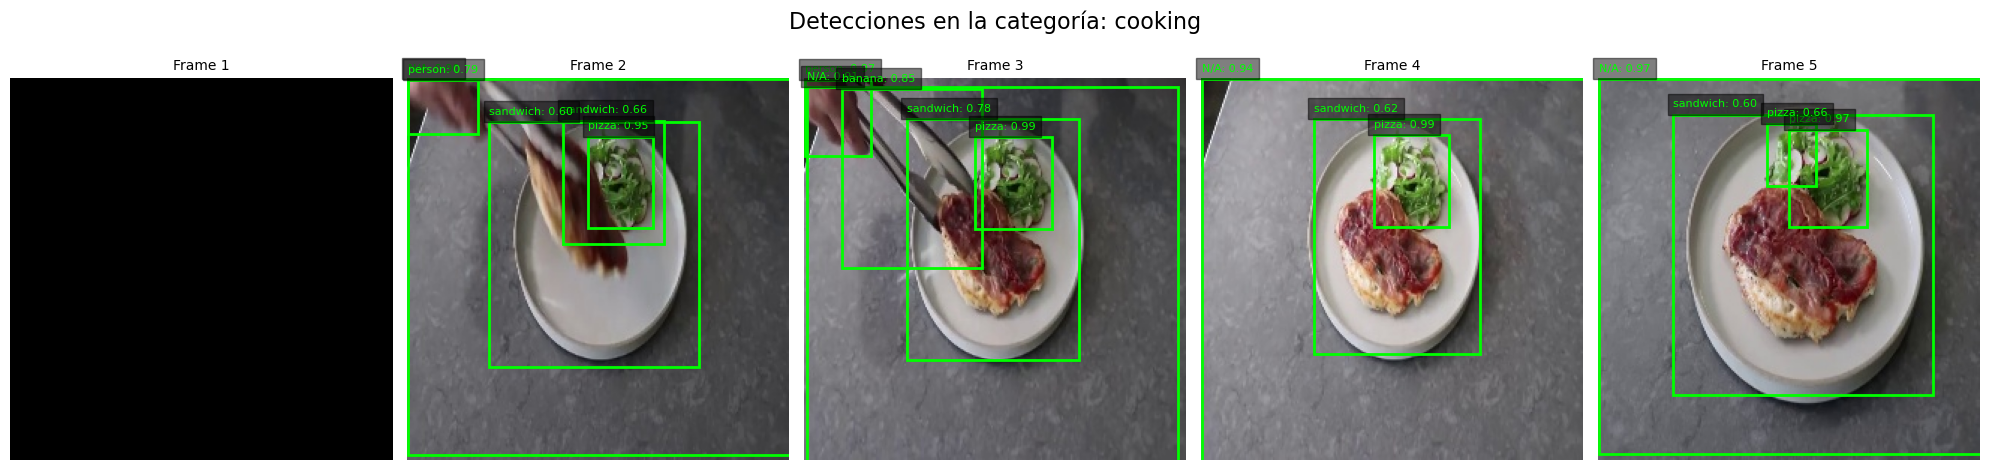

Visualizando frames para categoría: traffic


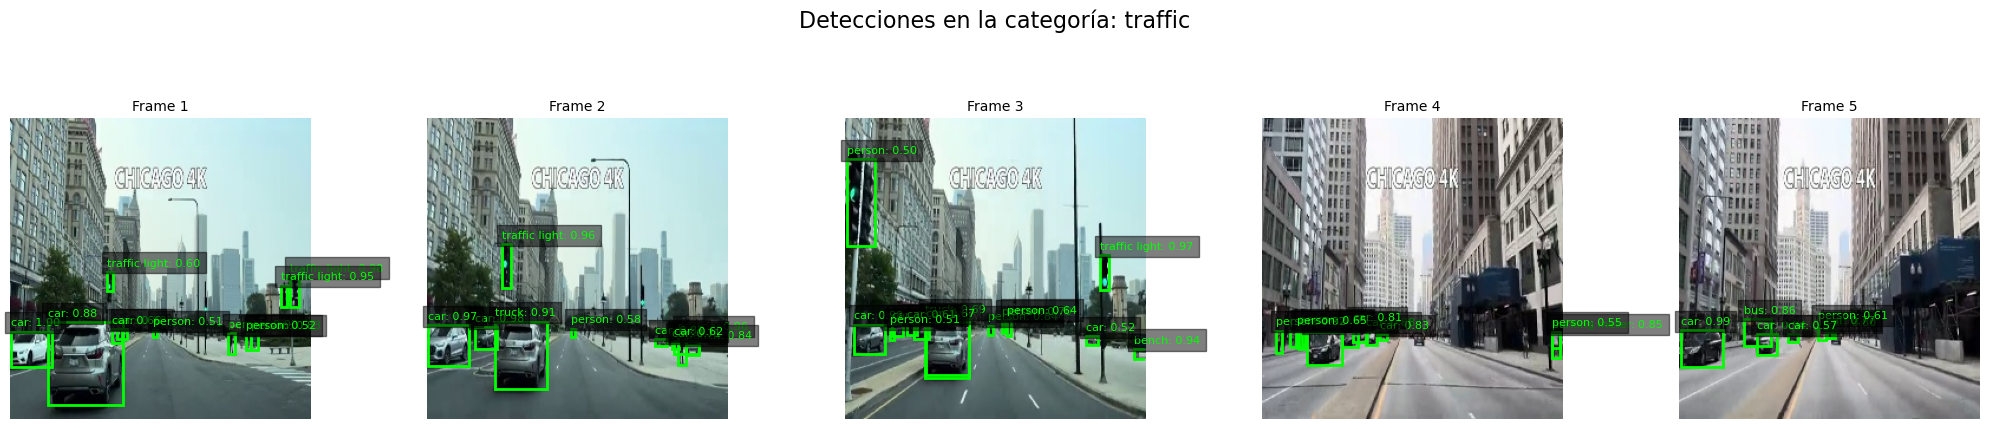

Visualizando frames para categoría: videoclip


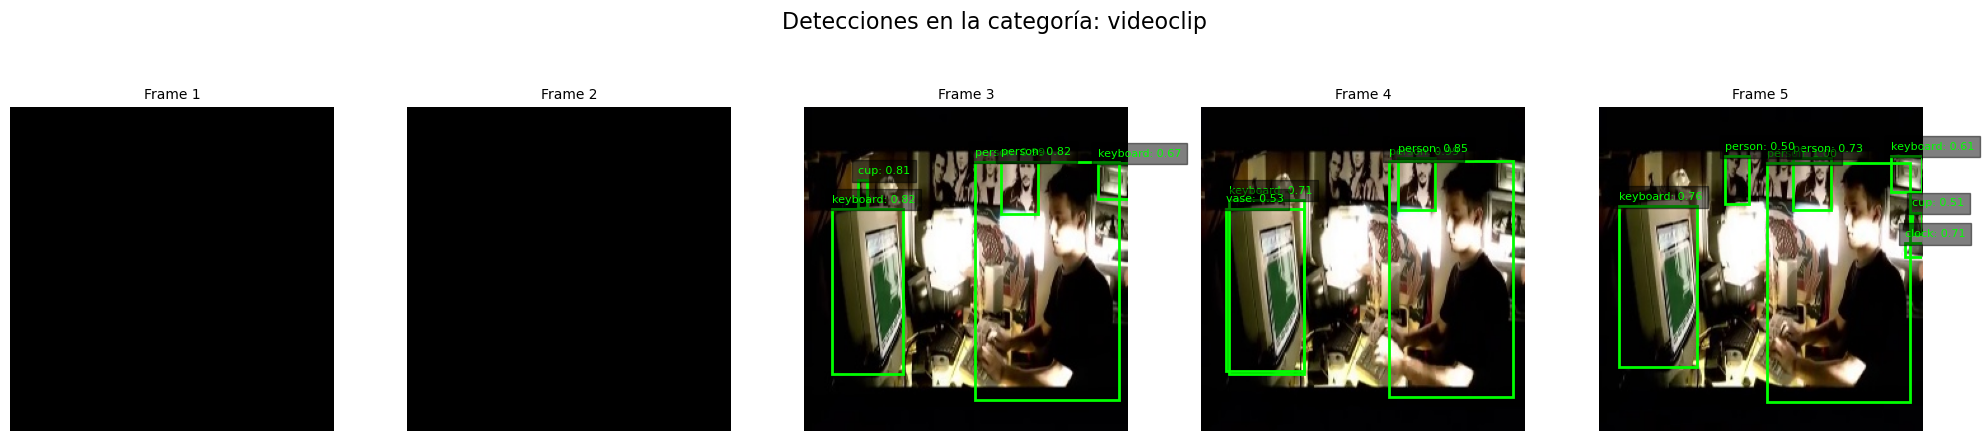

In [18]:
def visualize_grid(frames, predictions, coco_labels, category_name):
    num_frames = len(frames)                                                                                                    # Extraemos el número de frames,
    fig, axes = plt.subplots(1, num_frames, figsize=(20, 5))                                                                    # y generamos la rejilla con los subplots en fila.

    for i, (frame_path, prediction) in enumerate(zip(frames, predictions)):                                                     # Iteramos sobre los frames y predicciones.
        img = Image.open(frame_path).convert("RGB")                                                                             # Abriendo la imagen y la transforma a RGB,
        axes[i].imshow(img)                                                                                                     # muestra la imagen,
        axes[i].axis('off')                                                                                                     # oculta los ejes,
        axes[i].set_title(f"Frame {i+1}", fontsize=10)                                                                          # y titula el subplot.

        boxes = prediction['boxes']                                                                                             # Predice las cajas delimitadoras,
        labels = prediction['labels']                                                                                           # las etiquetas
        scores = prediction['scores']                                                                                           # y obtiene las puntuaciones.

        score_threshold = 0.5                                                                                                   # Definimos el umbral de puntuación para filtrar predicciones.

        for box, label, score in zip(boxes, labels, scores):                                                                    # Iteramos sobre las cajas, etiquetas y puntuaciones.
            if score >= score_threshold:                                                                                        # y filtramos predicciones según el umbral:
                x1, y1, x2, y2 = box.tolist()                                                                                   # Extrayendo las coordenadas de la caja,
                class_id = label.item()                                                                                         # convirtiendo la etiqueta,
                class_name = coco_labels[class_id] if class_id < len(coco_labels) else f"class_{class_id}"                      # extrayendo el nombre de la clase
                color = "lime"                                                                                                  # y marcando el color.

                # Bounding box
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')            # Marca el rectángulo delimitador de la caja
                axes[i].add_patch(rect)                                                                                         # y lo pasamos al subplot.

                # Etiqueta y puntuación
                axes[i].text(x1, y1 - 5, f"{class_name}: {score:.2f}", color=color, fontsize=8,                                 # Marcamos la etiqueta, la puntuación
                             bbox=dict(facecolor='black', alpha=0.5))                                                           # y el fondo.

    plt.tight_layout()
    plt.show()

# Visualización 
for category in os.listdir(processed_data_path):                                                                                # Iteramos sobre las categorías.
    category_path = os.path.join(processed_data_path, category)                                                                 # Generamos la ruta completa de la categoría
    if os.path.isdir(category_path):                                                                                            # y verificamos que sea un directorio
        print(f"Frames de: {category}")

        video_dirs = [os.path.join(category_path, dirs) for dirs in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, dirs))]      # Extraemos los directorios
        random.shuffle(video_dirs)                                                                                                                      # y aplicamos aleatoriedad.

        frames_to_visualize = []                                                                                                # Inicializamos las listas para los frames y predicciones.
        predictions_to_visualize = []

        for video_path in video_dirs:                                                                                           # Y por ultimo, iteramos sobre los directorios
            frames = [fr for fr in os.listdir(video_path) if fr.endswith('.jpg')]                                               # extrayendo los frames y ordenandolos.
            frames.sort()
            for frame_name in frames[:5]:                                                                                       # Iteramos sobre los 5 primeros
                frame_path = os.path.join(video_path, frame_name)                                                               # extraemos la ruta completa del frame,
                img_t = transform(Image.open(frame_path).convert("RGB")).to(device).unsqueeze(0)                                # y transformamso la imagen y la convertimos a tensor.

                with torch.no_grad():                                                                                           # Desactivamos el gradiente
                    prediction = model(img_t)[0]                                                                                # y realizamos la prediccion.

                frames_to_visualize.append(frame_path)                                                                          # Añadimos el frame a la lista de visualización y la predicción.
                predictions_to_visualize.append(prediction)

            if len(frames_to_visualize) >= 5:                                                                                   # Limitamos la muestra a 5 frames por cat.
                break  

        visualize_grid(frames_to_visualize[:5], predictions_to_visualize[:5], coco_labels, category)  

**Estupendo**. Vemos cómo el modelo, en general, está realizando un **buen trabajo** en la **detección de objetos** en cada una de las categorías. Sin embargo, **destacan ciertas limitaciones** a la hora de **identificar y reconocer objetos** que **confunde con otros** de la misma familia. Esto se debe a la **limitación en el entrenamiento** de las categorías del conjunto **COCO**.  